# Chapter 15: Autoencoders
-----
-----

Neural networks capable of learning efficient representations of input data, called codings, without supervision.
- coding have lower dimensionality the inputs making its useful for dimensionality reduction.
- act as powerful feature detectors.
- can be used for unsupervised pretraining of deep neural nets.
- capable of generating new data that looks similar to training data.(Generative Models)

Works by simply learning to copy their inputs to their outputs. 

Codings are the byproduct of the autoencoder's attempt to learn the identity function under some constaints.

## Efficient Data Representation'
-----
It is a fact that it is hard to memorize long sequences that makes it useful to recognize patters. So constraining an autoencoder during trains pushes it to discover and exploit patterns in the data.

Auto encoder looks at inputs, converts them to an efficient internal representation, and spits out something that looks very close to the inputs.

Composed of two partsl:
- encoder(recognition network): converts inputs to internal representations
- decoder(generative network): converts internal representations to outputs

number of neurons in output layer must be equal to number of inputs.

When the internal representation has a lower dimensionality than the input data, the autoencoder is undercomplete

## Performing PCA with an Undercomplete Linear Autoencoder
-----

If autoencoder uses only linear activations and cost function is mean squared error, then it can be shown that it ends up preforming PCA

In [1]:
# Common imports
import numpy as np
import os
import sys
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [4]:
reset_graph()

n_inputs = 3 # 3D inputs
n_hidden = 2 # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [5]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

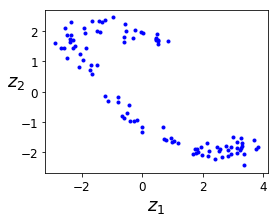

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

## Stacked Autoencoders
-----

Adding more layers help the autocoder learn more complex codings, but don't make the autoencoder too powerful.

The architecture of stacked autoencoders is typically symmetrical with regards to the central hidden layer.

#### Tensorflow Implementation

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Instructions for updating:
Please write your own downloading logic.


Instructions for updating:
Please use urllib or similar directly.


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting /tmp/data/train-images-idx3-ubyte.gz


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting /tmp/data/train-labels-idx1-ubyte.gz


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [9]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [10]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()                                         
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "tmp_models/ch15_autoencoder_mnist_1.ckpt")

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.021044808


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.011415727


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.010224738


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train MSE: 0.00990113


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 Train MSE: 0.010373585


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

5 Train MSE: 0.010959586


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

6 Train MSE: 0.01082996


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

7 Train MSE: 0.011317243


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

8 Train MSE: 0.011839613


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

9 Train MSE: 0.013172983


INFO:tensorflow:Restoring parameters from tmp_models/ch15_autoencoder_mnist_1.ckpt


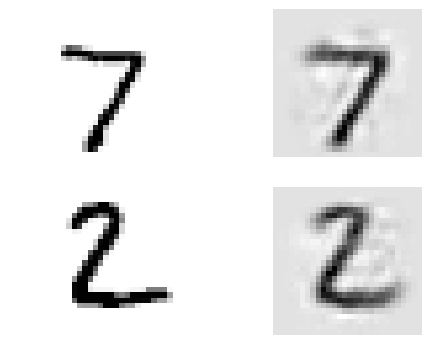

In [11]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
show_reconstructed_digits(X, outputs, "tmp_models/ch15_autoencoder_mnist_1.ckpt")

#### Trying Weights
When symmetrical, a common technique is to tie the weights of the decoder layers to the weights of the encoder layers. This speeds up training a limits the risk of overfitting.

in tensorflow, we cannot user tf.layers.dense()

In [12]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [13]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


In [14]:
saver = tf.train.Saver()

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "tmp_models/ch15_autoencoder_mnist_2.ckpt")

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.014792439


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.016511086


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.016656315


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train MSE: 0.01720544


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 Train MSE: 0.018368484


INFO:tensorflow:Restoring parameters from tmp_models/ch15_autoencoder_mnist_2.ckpt


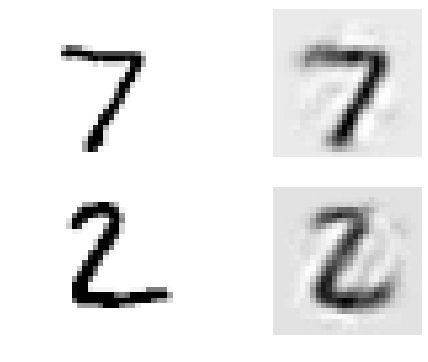

In [15]:
show_reconstructed_digits(X, outputs, "tmp_models/ch15_autoencoder_mnist_2.ckpt")

Things to note:
- weights 3 and 4 are not variables, they are transpose of weights 2 and weight 1
- since weight 3 and 4 are not variables we do not regularize them only 2 and 1
- biases are never tied and never regularized

#### Training One Autoencoder at a Time

Rather than training a whole stacked autoencoder in one go, it is often much faster to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder

Multigraph solution:

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.018870592
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.018815987
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.019538868
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train MSE: 0.01834963


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.004380443
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.0048327753
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.004805358
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train MSE: 0.0046959817


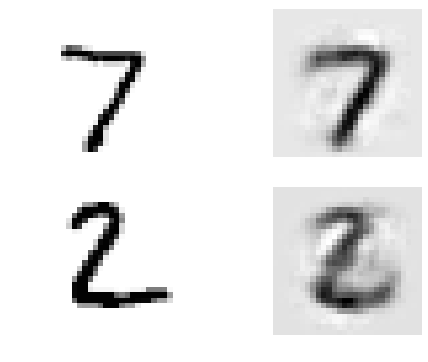

In [16]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]
    
    

hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)


reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

show_reconstructed_digits(X, outputs)

Other option is tio use single graph containing the whole stacked autoencoder plus some extra operations to preform each training phase.

In [17]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [18]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1


In [19]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [20]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "tmp_models/ch15_autoencoder_mnist_3.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.007861129


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.0077607217


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.0076983958


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train MSE: 0.008039911


Training phase #2
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.16528122


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.00544062


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.0026057293


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train MSE: 0.0021112463


Test MSE: 0.009654222


In [21]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "tmp_models/ch15_autoencoder_mnist_4.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.007922323


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.007407212


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.008290924


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train MSE: 0.0075644813


Training phase #2


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.07639633


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.0038873868


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.002245204


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3

 Train MSE: 0.0020515702


Test MSE: 0.009735605


#### Visualizing the Reconstructions
best way to know of well the outputs compare to the inputs

INFO:tensorflow:Restoring parameters from tmp_models/ch15_autoencoder_mnist_3.ckpt


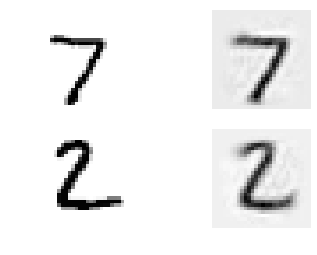

In [22]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "tmp_models/ch15_autoencoder_mnist_3.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

#### Visualizing Features
Simplest technique, is to consider each neuron in every hidden layer, and find the training instances that activated it the most. Doesn't really work too well when looking for lower layers.

Another technique: For each neuron in the first hidden layer, you can create an image where a pixel;s intensity corresponds to the weight of the connection to the given neuron.

INFO:tensorflow:Restoring parameters from tmp_models/ch15_autoencoder_mnist_3.ckpt


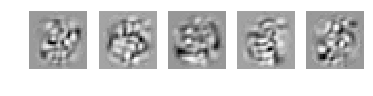

In [23]:
with tf.Session() as sess:
    saver.restore(sess, "tmp_models/ch15_autoencoder_mnist_3.ckpt")
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])
plt.show()

Another technique: feed the autoencoder a random image, measure the activation of the neuron you are interested int, and preform backprop to tweak the image in such a way that the neuron will activate even more.

## Unsupervised Pretraining Using Stacked Autoencoders
-----
Having large amount of unlabled data, you can train a stacked autoencoder, then reuse the lower layers to create a neural net for your actual task, and train it using labeled data.

In [24]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [25]:
# without pretraining
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "tmp_models/ch15_my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

0 Train accuracy: 0.9266667 

Test accuracy: 0.9366
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

1 Train accuracy: 0.96666664 

Test accuracy: 0.9377
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

2 Train accuracy: 0.99333334 

Test accuracy: 0.9435
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

3 Train accuracy: 0.98 

Test accuracy: 0.9503


In [26]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "tmp_models/ch15_my_model_supervised.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "tmp_models/ch15_my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from tmp_models/ch15_my_model_supervised.ckpt


0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

0 Train accuracy: 0.98	

Test accuracy: 0.9421
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

1 Train accuracy: 0.97333336	

Test accuracy: 0.9439
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

2 Train accuracy: 0.96666664	

Test accuracy: 0.9301
0%

0%

1%

2%

3%

3%

4%

5%

6%

6%

7%

8%

9%

9%

10%

11%

12%

12%

13%

14%

15%

15%

16%

17%

18%

18%

19%

20%

21%

21%

22%

23%

24%

24%

25%

26%

27%

27%

28%

29%

30%

30%

31%

32%

33%

33%

34%

35%

36%

36%

37%

38%

39%

39%

40%

41%

42%

42%

43%

44%

45%

45%

46%

47%

48%

48%

49%

50%

51%

51%

52%

53%

54%

54%

55%

56%

57%

57%

58%

59%

60%

60%

61%

62%

63%

63%

64%

65%

66%

66%

67%

68%

69%

69%

70%

71%

72%

72%

73%

74%

75%

75%

76%

77%

78%

78%

79%

80%

81%

81%

82%

83%

84%

84%

85%

86%

87%

87%

88%

89%

90%

90%

91%

92%

93%

93%

94%

95%

96%

96%

97%

98%

99%

3 Train accuracy: 0.96	

Test accuracy: 0.94


## Denoising Autoencoders
-----

Adding noise is a useful way to force the autoencoder to learn features, training it to recover the original, noise-free input.

Noise can be Gaussian:

In [27]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [28]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")                           
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")                            
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [29]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "tmp_models/ch15_my_model_stacked_denoising_gaussian.ckpt")

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.04727295


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.044589177


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.043600883


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train MSE: 0.04345771


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 Train MSE: 0.042910438


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

5 Train MSE: 0.042931914


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

6 Train MSE: 0.04379513


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

7 Train MSE: 0.044266146


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

8 Train MSE: 0.042252377


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

9 Train MSE: 0.042379174


Using dropout noise

In [30]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [32]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "tmp_models/ch15_my_model_stacked_denoising_dropout.ckpt")

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train MSE: 0.028116565


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train MSE: 0.024856338


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train MSE: 0.026392436


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train MSE: 0.023961073


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 Train MSE: 0.023915516


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

5 Train MSE: 0.02360526


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

6 Train MSE: 0.024284432


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

7 Train MSE: 0.022956716


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

8 Train MSE: 0.024065506


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

9 Train MSE: 0.023740496


INFO:tensorflow:Restoring parameters from tmp_models/ch15_my_model_stacked_denoising_dropout.ckpt


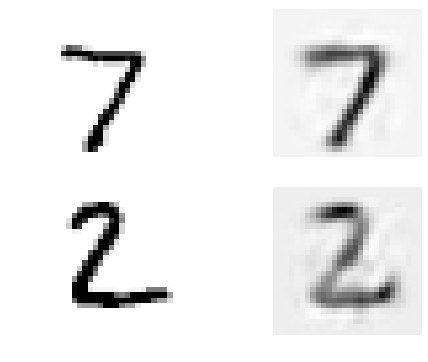

In [33]:
show_reconstructed_digits(X, outputs, "tmp_models/ch15_my_model_stacked_denoising_dropout.ckpt")

## Sparse Autoencoders
-----

Another kind of contraint that often leads to good feature extraction is sparsity: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer.

First measure the actual sparsity of the coding layer at each training iteration. done by computing the average activations of each nueron in the coding layer, over the whole training batch.

after we want to penalize the neurons that are too active by adding a sparsity loss to the cost function.

once the sparsity loss has been computed for each neuron in the coding layer, we sum up the loss and add the result to the cost function.

#### Tensorflow Implementation

In [34]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [35]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [36]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [37]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "tmp_models/ch15_my_model_sparse.ckpt")

0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

0 Train MSE: 0.11914348 	Sparsity loss: 0.794243 	Total loss: 0.27799207


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

1 Train MSE: 0.05933444 	Sparsity loss: 0.03541257 	Total loss: 0.06641695


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

2 Train MSE: 0.053207275 	Sparsity loss: 0.13861522 	Total loss: 0.08093032


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

3 Train MSE: 0.0491809 	Sparsity loss: 0.022234047 	Total loss: 0.053627707


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

4 Train MSE: 0.04459012 	Sparsity loss: 0.099810764 	Total loss: 0.06455227


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

5 Train MSE: 0.043501053 	Sparsity loss: 0.021587534 	Total loss: 0.04781856


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

6 Train MSE: 0.039435666 	Sparsity loss: 0.060270727 	Total loss: 0.05148981


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

7 Train MSE: 0.037295662 	Sparsity loss: 0.12071499 	Total loss: 0.06143866


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

8 Train MSE: 0.03378141 	Sparsity loss: 0.017655512 	Total loss: 0.03731251


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

9 Train MSE: 0.02994395 	Sparsity loss: 0.010829199 	Total loss: 0.03210979


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

10 Train MSE: 0.026360994 	Sparsity loss: 0.2002334 	Total loss: 0.06640767


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

11 Train MSE: 0.025853015 	Sparsity loss: 0.040038876 	Total loss: 0.03386079


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

12 Train MSE: 0.023900142 	Sparsity loss: 0.20029292 	Total loss: 0.06395873


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

13 Train MSE: 0.022268161 	Sparsity loss: 0.09525665 	Total loss: 0.04131949


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

14 Train MSE: 0.020949323 	Sparsity loss: 0.027767902 	Total loss: 0.026502904


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

15 Train MSE: 0.020454679 	Sparsity loss: 0.083830796 	Total loss: 0.037220836


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

16 Train MSE: 0.019891694 	Sparsity loss: 0.027491359 	Total loss: 0.025389966


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

17 Train MSE: 0.018580874 	Sparsity loss: 0.06466452 	Total loss: 0.03151378


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

18 Train MSE: 0.018346492 	Sparsity loss: 0.04904878 	Total loss: 0.028156249


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

19 Train MSE: 0.017263604 	Sparsity loss: 0.054582614 	Total loss: 0.028180126


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

20 Train MSE: 0.016307872 	Sparsity loss: 0.20404777 	Total loss: 0.057117425


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

21 Train MSE: 0.016426748 	Sparsity loss: 0.037698887 	Total loss: 0.023966525


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

22 Train MSE: 0.016388284 	Sparsity loss: 0.20511234 	Total loss: 0.057410754


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

23 Train MSE: 0.016641643 	Sparsity loss: 0.07752949 	Total loss: 0.03214754


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

24 Train MSE: 0.015075875 	Sparsity loss: 0.046019062 	Total loss: 0.024279688


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

25 Train MSE: 0.014499619 	Sparsity loss: 0.059113767 	Total loss: 0.026322372


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

26 Train MSE: 0.014561993 	Sparsity loss: 0.058192614 	Total loss: 0.026200516


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

27 Train MSE: 0.014147274 	Sparsity loss: 0.079842724 	Total loss: 0.030115819


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

28 Train MSE: 0.015058246 	Sparsity loss: 0.07635065 	Total loss: 0.030328378


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

29 Train MSE: 0.014438491 	Sparsity loss: 0.07150687 	Total loss: 0.028739866


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

30 Train MSE: 0.014148719 	Sparsity loss: 0.13443625 	Total loss: 0.04103597


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

31 Train MSE: 0.014020168 	Sparsity loss: 0.105557546 	Total loss: 0.035131678


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

32 Train MSE: 0.013295935 	Sparsity loss: 0.066326156 	Total loss: 0.026561167


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

33 Train MSE: 0.016337248 	Sparsity loss: 0.041216634 	Total loss: 0.024580576


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

34 Train MSE: 0.012974326 	Sparsity loss: 0.03343688 	Total loss: 0.019661702


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

35 Train MSE: 0.014070538 	Sparsity loss: 0.06817474 	Total loss: 0.027705487


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

36 Train MSE: 0.013313125 	Sparsity loss: 0.06446032 	Total loss: 0.02620519


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

37 Train MSE: 0.013075882 	Sparsity loss: 0.08553694 	Total loss: 0.03018327


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

38 Train MSE: 0.013098448 	Sparsity loss: 0.2958401 	Total loss: 0.07226647


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

39 Train MSE: 0.013470786 	Sparsity loss: 0.057242118 	Total loss: 0.024919208


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

40 Train MSE: 0.012630956 	Sparsity loss: 0.13051547 	Total loss: 0.03873405


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

41 Train MSE: 0.013013482 	Sparsity loss: 0.07134563 	Total loss: 0.027282607


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

42 Train MSE: 0.012493971 	Sparsity loss: 0.060711842 	Total loss: 0.02463634


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

43 Train MSE: 0.012586889 	Sparsity loss: 0.10257451 	Total loss: 0.033101793


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

44 Train MSE: 0.01218988 	Sparsity loss: 0.12021534 	Total loss: 0.03623295


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

45 Train MSE: 0.012139013 	Sparsity loss: 0.08653563 	Total loss: 0.02944614


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

46 Train MSE: 0.013520789 	Sparsity loss: 0.17482537 	Total loss: 0.048485864


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

47 Train MSE: 0.011841001 	Sparsity loss: 0.07352483 	Total loss: 0.026545968


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

48 Train MSE: 0.012899456 	Sparsity loss: 0.17711052 	Total loss: 0.04832156


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

49 Train MSE: 0.011615478 	Sparsity loss: 0.1404004 	Total loss: 0.039695557


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

50 Train MSE: 0.012114361 	Sparsity loss: 0.18029666 	Total loss: 0.048173692


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

51 Train MSE: 0.012404067 	Sparsity loss: 0.14930958 	Total loss: 0.04226598


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

52 Train MSE: 0.0112222675 	Sparsity loss: 0.15900221 	Total loss: 0.043022715


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

53 Train MSE: 0.011565305 	Sparsity loss: 0.34920466 	Total loss: 0.081406236


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

54 Train MSE: 0.011388929 	Sparsity loss: 0.13165563 	Total loss: 0.037720054


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

55 Train MSE: 0.011269438 	Sparsity loss: 0.09782207 	Total loss: 0.030833852


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

56 Train MSE: 0.012145456 	Sparsity loss: 0.63184035 	Total loss: 0.13851354


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

57 Train MSE: 0.011526488 	Sparsity loss: 0.1299655 	Total loss: 0.03751959


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

58 Train MSE: 0.011957497 	Sparsity loss: 0.107245944 	Total loss: 0.033406686


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

59 Train MSE: 0.011321849 	Sparsity loss: 0.17317227 	Total loss: 0.045956302


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

60 Train MSE: 0.011473528 	Sparsity loss: 0.13162601 	Total loss: 0.03779873


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

61 Train MSE: 0.010940619 	Sparsity loss: 0.22059323 	Total loss: 0.055059265


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

62 Train MSE: 0.011919838 	Sparsity loss: 0.11109244 	Total loss: 0.034138326


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

63 Train MSE: 0.010779958 	Sparsity loss: 0.25553003 	Total loss: 0.061885964


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

64 Train MSE: 0.012865736 	Sparsity loss: 1.2229851 	Total loss: 0.25746277


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

65 Train MSE: 0.012020807 	Sparsity loss: 0.53522724 	Total loss: 0.11906625


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

66 Train MSE: 0.011515156 	Sparsity loss: 0.2680849 	Total loss: 0.06513214


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

67 Train MSE: 0.0133610675 	Sparsity loss: 0.24388675 	Total loss: 0.06213842


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

68 Train MSE: 0.02056979 	Sparsity loss: 0.11095124 	Total loss: 0.042760037


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

69 Train MSE: 0.01336392 	Sparsity loss: 0.20837626 	Total loss: 0.05503917


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

70 Train MSE: 0.011964301 	Sparsity loss: 0.22395626 	Total loss: 0.05675555


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

71 Train MSE: 0.012310808 	Sparsity loss: 0.2600824 	Total loss: 0.064327285


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

72 Train MSE: 0.032746453 	Sparsity loss: 0.22045006 	Total loss: 0.07683647


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

73 Train MSE: 0.015217604 	Sparsity loss: 0.30799314 	Total loss: 0.07681623


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

74 Train MSE: 0.032200463 	Sparsity loss: 0.27949193 	Total loss: 0.088098854


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

75 Train MSE: 0.013083068 	Sparsity loss: 0.3817195 	Total loss: 0.08942697


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

76 Train MSE: 0.014061522 	Sparsity loss: 0.3244654 	Total loss: 0.07895461


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

77 Train MSE: 0.012622674 	Sparsity loss: 0.07434832 	Total loss: 0.027492339


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

78 Train MSE: 0.033702347 	Sparsity loss: 0.2187787 	Total loss: 0.07745808


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

79 Train MSE: 0.018024098 	Sparsity loss: 0.1267445 	Total loss: 0.043372996


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

80 Train MSE: 0.013501553 	Sparsity loss: 0.15712444 	Total loss: 0.044926442


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

81 Train MSE: 0.011930351 	Sparsity loss: 0.27693728 	Total loss: 0.067317806


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

82 Train MSE: 0.016541693 	Sparsity loss: 1.5156962 	Total loss: 0.31968093


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

83 Train MSE: 0.0135949105 	Sparsity loss: 0.25353327 	Total loss: 0.064301565


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

84 Train MSE: 0.013456746 	Sparsity loss: 0.102543235 	Total loss: 0.033965394


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

85 Train MSE: 0.013025421 	Sparsity loss: 0.5292954 	Total loss: 0.1188845


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

86 Train MSE: 0.013385361 	Sparsity loss: 0.23705995 	Total loss: 0.06079735


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

87 Train MSE: 0.02756821 	Sparsity loss: 0.40315908 	Total loss: 0.10820003


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

88 Train MSE: 0.01319322 	Sparsity loss: 0.20791167 	Total loss: 0.054775555


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

89 Train MSE: 0.036031123 	Sparsity loss: 0.70251006 	Total loss: 0.17653315


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

90 Train MSE: 0.015950724 	Sparsity loss: 1.2397206 	Total loss: 0.26389486


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

91 Train MSE: 0.012451748 	Sparsity loss: 0.38833004 	Total loss: 0.09011775


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

92 Train MSE: 0.020102195 	Sparsity loss: 0.14145468 	Total loss: 0.04839313


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

93 Train MSE: 0.0150067285 	Sparsity loss: 0.1439035 	Total loss: 0.043787427


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

94 Train MSE: 0.01366175 	Sparsity loss: 0.106631465 	Total loss: 0.034988046


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

95 Train MSE: 0.013908583 	Sparsity loss: 0.13646097 	Total loss: 0.04120078


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

96 Train MSE: 0.018329151 	Sparsity loss: 0.362203 	Total loss: 0.09076975


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

97 Train MSE: 0.018860754 	Sparsity loss: 0.4966858 	Total loss: 0.11819792


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

98 Train MSE: 0.01725055 	Sparsity loss: 0.16043937 	Total loss: 0.049338423


0%

1%

3%

5%

7%

9%

10%

12%

14%

16%

18%

20%

21%

23%

25%

27%

29%

30%

32%

34%

36%

38%

40%

41%

43%

45%

47%

49%

50%

52%

54%

56%

58%

60%

61%

63%

65%

67%

69%

70%

72%

74%

76%

78%

80%

81%

83%

85%

87%

89%

90%

92%

94%

96%

98%

99 Train MSE: 0.015190257 	Sparsity loss: 0.13743491 	Total loss: 0.04267724


## Variational Autoencoders
-----

- Probabilistic autoencoders, meaning that their outputs are partly determined by chance, even after training
- Generative autoencoders, meaning they can generate new instances that look like they were sampled from the training set

Makes it similar to RBMs.

Similar basic structure to autoencoders(encoder followed by decoder), but instead of directly producting a coding, the encoder produces a mean coding and a standard deviation, the actual coding is randomly sampled from a Gaussian distribution with mean and std. The decoder just decodes the sampled coding normally.

cost function: has two parts
1. usual reconstruction loss that pushes the autoencoder to reproduce its inputs
2. latent loss that pushes the autoencoder to have coding that look as though they were sampled from a simple Gaussian distribution

In [38]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [39]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [41]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [42]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "tmp_models/ch15_my_model_variational.ckpt")

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train total loss: 30920.773 	Reconstruction loss: 24479.867 	Latent loss: 6440.9053


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train total loss: 30405.037 	Reconstruction loss: 24764.453 	Latent loss: 5640.584


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train total loss: 28169.732 	Reconstruction loss: 23871.738 	Latent loss: 4297.9937


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train total loss: 30869.78 	Reconstruction loss: 24495.564 	Latent loss: 6374.215


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 Train total loss: 28965.596 	Reconstruction loss: 22031.568 	Latent loss: 6934.028


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

5 Train total loss: 20449.305 	Reconstruction loss: 17132.688 	Latent loss: 3316.6167


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

6 Train total loss: 21421.768 	Reconstruction loss: 17624.033 	Latent loss: 3797.7336


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

7 Train total loss: 19050.686 	Reconstruction loss: 16250.181 	Latent loss: 2800.505


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

8 Train total loss: 17552.19 	Reconstruction loss: 14529.644 	Latent loss: 3022.5454


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

9 Train total loss: 16959.36 	Reconstruction loss: 13940.609 	Latent loss: 3018.751


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

10 Train total loss: 16698.303 	Reconstruction loss: 13543.03 	Latent loss: 3155.2722


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

11 Train total loss: 16187.132 	Reconstruction loss: 13216.406 	Latent loss: 2970.7253


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

12 Train total loss: 15764.691 	Reconstruction loss: 12617.572 	Latent loss: 3147.1194


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

13 Train total loss: 15808.773 	Reconstruction loss: 12740.588 	Latent loss: 3068.1858


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

14 Train total loss: 16372.488 	Reconstruction loss: 13254.271 	Latent loss: 3118.2163


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

15 Train total loss: 16470.277 	Reconstruction loss: 13211.527 	Latent loss: 3258.7507


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

16 Train total loss: 15784.823 	Reconstruction loss: 12519.915 	Latent loss: 3264.9082


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

17 Train total loss: 15789.638 	Reconstruction loss: 12558.09 	Latent loss: 3231.5476


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

18 Train total loss: 15685.245 	Reconstruction loss: 12525.375 	Latent loss: 3159.8704


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

19 Train total loss: 26852.488 	Reconstruction loss: 22138.803 	Latent loss: 4713.686


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

20 Train total loss: 24836.299 	Reconstruction loss: 20600.312 	Latent loss: 4235.9863


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

21 Train total loss: 28384.953 	Reconstruction loss: 22280.938 	Latent loss: 6104.016


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

22 Train total loss: 27613.508 	Reconstruction loss: 21933.781 	Latent loss: 5679.7266


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

23 Train total loss: 26695.918 	Reconstruction loss: 22061.71 	Latent loss: 4634.206


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

24 Train total loss: 26894.219 	Reconstruction loss: 21065.46 	Latent loss: 5828.757


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

25 Train total loss: 27217.924 	Reconstruction loss: 20176.402 	Latent loss: 7041.5215


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

26 Train total loss: 22897.785 	Reconstruction loss: 19187.371 	Latent loss: 3710.4146


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

27 Train total loss: 17958.871 	Reconstruction loss: 14981.42 	Latent loss: 2977.4504


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

28 Train total loss: 17182.441 	Reconstruction loss: 13993.952 	Latent loss: 3188.4902


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

29 Train total loss: 16216.725 	Reconstruction loss: 13069.148 	Latent loss: 3147.5764


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

30 Train total loss: 16428.77 	Reconstruction loss: 13149.8955 	Latent loss: 3278.8738


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

31 Train total loss: 16676.785 	Reconstruction loss: 13497.584 	Latent loss: 3179.202


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

32 Train total loss: 16214.18 	Reconstruction loss: 13099.085 	Latent loss: 3115.0945


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

33 Train total loss: 16091.313 	Reconstruction loss: 12969.669 	Latent loss: 3121.6448


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

34 Train total loss: 16080.33 	Reconstruction loss: 12833.043 	Latent loss: 3247.2876


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

35 Train total loss: 15707.07 	Reconstruction loss: 12422.701 	Latent loss: 3284.3687


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

36 Train total loss: 15922.172 	Reconstruction loss: 12646.513 	Latent loss: 3275.6592


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

37 Train total loss: 20625.408 	Reconstruction loss: 17363.82 	Latent loss: 3261.588


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

38 Train total loss: 19867.758 	Reconstruction loss: 15696.342 	Latent loss: 4171.4165


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

39 Train total loss: 16592.107 	Reconstruction loss: 13271.066 	Latent loss: 3321.0408


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

40 Train total loss: 15827.0 	Reconstruction loss: 12634.593 	Latent loss: 3192.4067


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

41 Train total loss: 15463.531 	Reconstruction loss: 12297.461 	Latent loss: 3166.0703


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

42 Train total loss: 15426.918 	Reconstruction loss: 12236.344 	Latent loss: 3190.5745


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

43 Train total loss: 20628.979 	Reconstruction loss: 15232.213 	Latent loss: 5396.766


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

44 Train total loss: 21993.068 	Reconstruction loss: 17931.895 	Latent loss: 4061.1733


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

45 Train total loss: 24599.186 	Reconstruction loss: 20135.506 	Latent loss: 4463.68


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

46 Train total loss: 18430.416 	Reconstruction loss: 15365.125 	Latent loss: 3065.2905


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

47 Train total loss: 16463.172 	Reconstruction loss: 13366.697 	Latent loss: 3096.474


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

48 Train total loss: 16410.855 	Reconstruction loss: 13173.244 	Latent loss: 3237.6123


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

49 Train total loss: 16016.688 	Reconstruction loss: 12824.357 	Latent loss: 3192.331


#### Generating Digits

Using the variational autoencoder to generate images

In [45]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [46]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  # not shown
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

0 Train total loss: 17829.484 	Reconstruction loss: 14141.81 	Latent loss: 3687.6758


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

1 Train total loss: 17168.229 	Reconstruction loss: 13355.197 	Latent loss: 3813.0312


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

2 Train total loss: 16518.21 	Reconstruction loss: 12733.113 	Latent loss: 3785.0977


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

3 Train total loss: 16210.246 	Reconstruction loss: 12441.067 	Latent loss: 3769.1792


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

4 Train total loss: 15651.391 	Reconstruction loss: 11851.788 	Latent loss: 3799.6028


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

5 Train total loss: 16558.977 	Reconstruction loss: 12747.469 	Latent loss: 3811.5078


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

6 Train total loss: 15713.162 	Reconstruction loss: 11908.602 	Latent loss: 3804.5603


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

7 Train total loss: 16004.131 	Reconstruction loss: 12262.653 	Latent loss: 3741.4773


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

8

 Train total loss: 16123.536 	Reconstruction loss: 12269.502 	Latent loss: 3854.0342


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

9 Train total loss: 15220.478 	Reconstruction loss: 11528.266 	Latent loss: 3692.2122


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

10 Train total loss: 16035.865 	Reconstruction loss: 12183.934 	Latent loss: 3851.9321


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

11 Train total loss: 15490.658 	Reconstruction loss: 11836.07 	Latent loss: 3654.5876


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

12 Train total loss: 15432.666 	Reconstruction loss: 11627.678 	Latent loss: 3804.9878


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

13 Train total loss: 15760.684 	Reconstruction loss: 12051.428 	Latent loss: 3709.2554


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

14 Train total loss: 15898.374 	Reconstruction loss: 12017.738 	Latent loss: 3880.6357


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

15 Train total loss: 15394.532 	Reconstruction loss: 11647.529 	Latent loss: 3747.003


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

16 Train total loss: 15451.115 	Reconstruction loss: 11652.861 	Latent loss: 3798.2542


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

17 Train total loss: 15397.277 	Reconstruction loss: 11620.215 	Latent loss: 3777.0627


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

18 Train total loss: 15177.424 	Reconstruction loss: 11407.814 	Latent loss: 3769.609


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

19 Train total loss: 15951.599 	Reconstruction loss: 12037.231 	Latent loss: 3914.3674


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

20 Train total loss: 16005.308 	Reconstruction loss: 12172.208 	Latent loss: 3833.0994


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

21 Train total loss: 14994.503 	Reconstruction loss: 11176.553 	Latent loss: 3817.9502


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

22 Train total loss: 15272.511 	Reconstruction loss: 11416.053 	Latent loss: 3856.4583


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

23 Train total loss: 15045.225 	Reconstruction loss: 11256.552 	Latent loss: 3788.673


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

24 Train total loss: 15024.787 	Reconstruction loss: 11303.893 	Latent loss: 3720.894


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

25 Train total loss: 14785.432 	Reconstruction loss: 11097.038 	Latent loss: 3688.3938


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

26 Train total loss: 15242.585 	Reconstruction loss: 11465.516 	Latent loss: 3777.0693


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

27 Train total loss: 15368.106 	Reconstruction loss: 11536.102 	Latent loss: 3832.0051


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

28 Train total loss: 15028.234 	Reconstruction loss: 11373.291 	Latent loss: 3654.9438


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

29 Train total loss: 15003.908 	Reconstruction loss: 11229.323 	Latent loss: 3774.5852


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

30 Train total loss: 15334.198 	Reconstruction loss: 11551.022 	Latent loss: 3783.176


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

31 Train total loss: 15056.559 	Reconstruction loss: 11264.932 	Latent loss: 3791.6267


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

32 Train total loss: 14869.158 	Reconstruction loss: 11175.025 	Latent loss: 3694.1333


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

33 Train total loss: 15233.487 	Reconstruction loss: 11615.734 	Latent loss: 3617.753


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

34 Train total loss: 14862.424 	Reconstruction loss: 11123.135 	Latent loss: 3739.2893


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

35 Train total loss: 14568.301 	Reconstruction loss: 10995.988 	Latent loss: 3572.313


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

36 Train total loss: 15006.093 	Reconstruction loss: 11311.31 	Latent loss: 3694.7834


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

37 Train total loss: 15170.949 	Reconstruction loss: 11466.444 	Latent loss: 3704.505


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

38 Train total loss: 14945.552 	Reconstruction loss: 11137.139 	Latent loss: 3808.413


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

39 Train total loss: 14900.096 	Reconstruction loss: 11194.512 	Latent loss: 3705.584


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

40 Train total loss: 14997.484 	Reconstruction loss: 11277.775 	Latent loss: 3719.7085


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

41 Train total loss: 14724.308 	Reconstruction loss: 11084.62 	Latent loss: 3639.6877


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

42 Train total loss: 14809.674 	Reconstruction loss: 11207.49 	Latent loss: 3602.184


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

43 Train total loss: 15222.097 	Reconstruction loss: 11364.287 	Latent loss: 3857.8096


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

44 Train total loss: 15263.242 	Reconstruction loss: 11432.521 	Latent loss: 3830.7202


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

45 Train total loss: 15118.394 	Reconstruction loss: 11362.305 	Latent loss: 3756.089


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

46 Train total loss: 14766.316 	Reconstruction loss: 11010.625 	Latent loss: 3755.6917


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

47 Train total loss: 15152.727 	Reconstruction loss: 11314.721 	Latent loss: 3838.0063


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

48 Train total loss: 14744.856 	Reconstruction loss: 10962.0 	Latent loss: 3782.8564


0%

0%

0%

0%

1%

1%

1%

1%

2%

2%

2%

3%

3%

3%

3%

4%

4%

4%

4%

5%

5%

5%

6%

6%

6%

6%

7%

7%

7%

7%

8%

8%

8%

9%

9%

9%

9%

10%

10%

10%

10%

11%

11%

11%

12%

12%

12%

12%

13%

13%

13%

13%

14%

14%

14%

15%

15%

15%

15%

16%

16%

16%

16%

17%

17%

17%

18%

18%

18%

18%

19%

19%

19%

19%

20%

20%

20%

21%

21%

21%

21%

22%

22%

22%

22%

23%

23%

23%

24%

24%

24%

24%

25%

25%

25%

25%

26%

26%

26%

27%

27%

27%

27%

28%

28%

28%

28%

29%

29%

29%

30%

30%

30%

30%

31%

31%

31%

31%

32%

32%

32%

33%

33%

33%

33%

34%

34%

34%

34%

35%

35%

35%

36%

36%

36%

36%

37%

37%

37%

37%

38%

38%

38%

39%

39%

39%

39%

40%

40%

40%

40%

41%

41%

41%

42%

42%

42%

42%

43%

43%

43%

43%

44%

44%

44%

45%

45%

45%

45%

46%

46%

46%

46%

47%

47%

47%

48%

48%

48%

48%

49%

49%

49%

50%

50%

50%

50%

51%

51%

51%

51%

52%

52%

52%

53%

53%

53%

53%

54%

54%

54%

54%

55%

55%

55%

56%

56%

56%

56%

57%

57%

57%

57%

58%

58%

58%

59%

59%

59%

59%

60%

60%

60%

60%

61%

61%

61%

62%

62%

62%

62%

63%

63%

63%

63%

64%

64%

64%

65%

65%

65%

65%

66%

66%

66%

66%

67%

67%

67%

68%

68%

68%

68%

69%

69%

69%

69%

70%

70%

70%

71%

71%

71%

71%

72%

72%

72%

72%

73%

73%

73%

74%

74%

74%

74%

75%

75%

75%

75%

76%

76%

76%

77%

77%

77%

77%

78%

78%

78%

78%

79%

79%

79%

80%

80%

80%

80%

81%

81%

81%

81%

82%

82%

82%

83%

83%

83%

83%

84%

84%

84%

84%

85%

85%

85%

86%

86%

86%

86%

87%

87%

87%

87%

88%

88%

88%

89%

89%

89%

89%

90%

90%

90%

90%

91%

91%

91%

92%

92%

92%

92%

93%

93%

93%

93%

94%

94%

94%

95%

95%

95%

95%

96%

96%

96%

96%

97%

97%

97%

98%

98%

98%

98%

99%

99%

99%

49 Train total loss: 14026.087 	Reconstruction loss: 10385.232 	Latent loss: 3640.8542


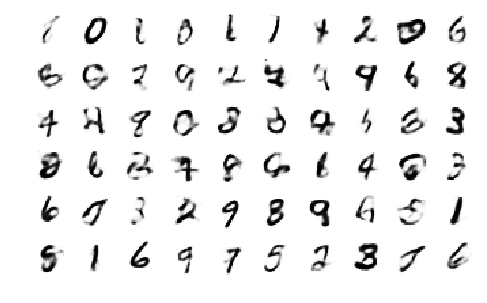

In [48]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

## Other Autoencoders
-----

- Contractive Autoencoder
- stacked convolutional autoencoder
- generative stochastic network
- winner-take-all autoencoder
- adversarial autoencoder

## Exercises

1. 
	- dimensionality reduction
	- feature extraction
	- unsupervised pretraining
	- generative models
	- anomaly detection
2. first train entire data set on autoencoder, take the lower half of the autoencoder and use it in the classifier and training it on the labeled data.
3. Not necessarily, it might be overfitting the training data. or overcomplete. performance can be evaluated by looking at the reconstruction loss, high loss is bad, but low loss it not necessarily good.
4. undercomplete: coding layer smaller than input and output layer. Overcomplete: coding layer larger, may just copy input to outputs not learning any useful features.
5. decode weight = transpose of encoding weights. reduces num of parameters, helps converge faster, reduces the risk of overfitting.
6. lower layers: plotting the weight of each neuron. higher layer: displaying training instance that most activated the neurons
7. model that can generate instances that are like the ones found in the training data